# 트리 모델의 변수중요도


## 1.환경준비

### 1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기

In [ ]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)
x_train.shape

(404, 13)

## 3.Feature Importance

### 1) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import *

* 기본 모델

In [ ]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

* 모델 시각화

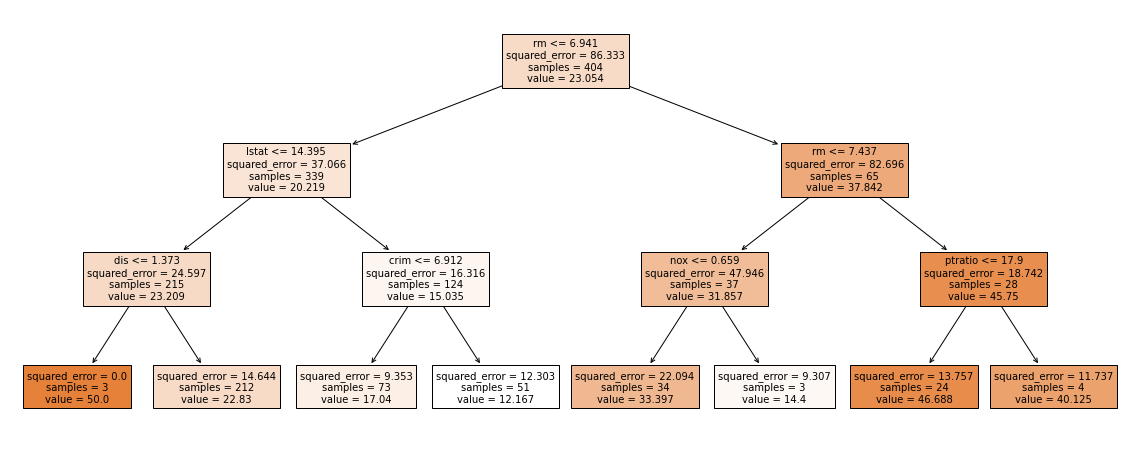

In [ ]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10)
plt.show()

* 변수 중요도

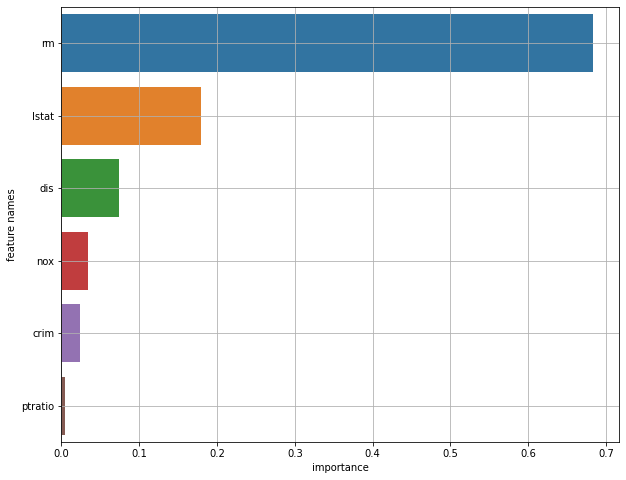

In [ ]:
result = plot_feature_importance(model.feature_importances_, list(x), 6)

In [ ]:
result

,feature_names,feature_importance
0,rm,0.682914
1,lstat,0.179261
2,dis,0.074513
3,nox,0.033946
4,crim,0.024328
5,ptratio,0.005038


* 성능 최적화 이후 변수 중요도 다시 확인

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

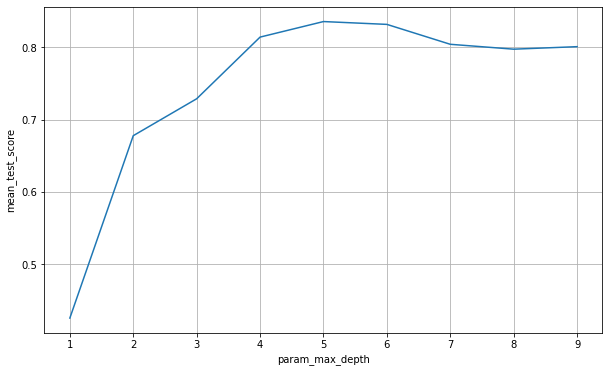

In [ ]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [ ]:
best_model = model_gs.best_estimator_

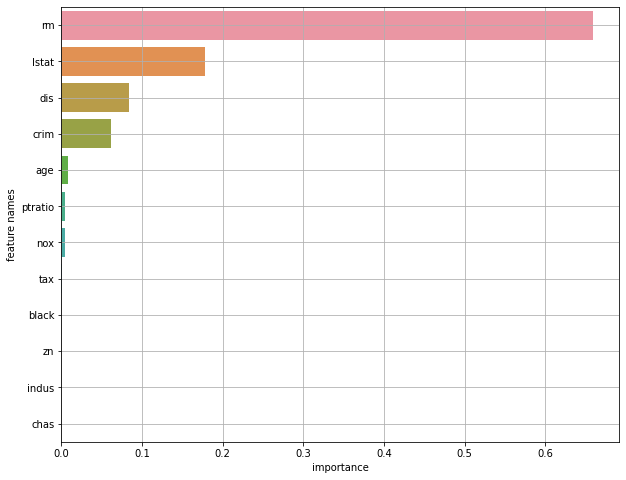

In [ ]:
result = plot_feature_importance(best_model.feature_importances_, list(x),12)

In [ ]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

3.1933449978231763


### 2) Random Forest

* 기본모델링

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

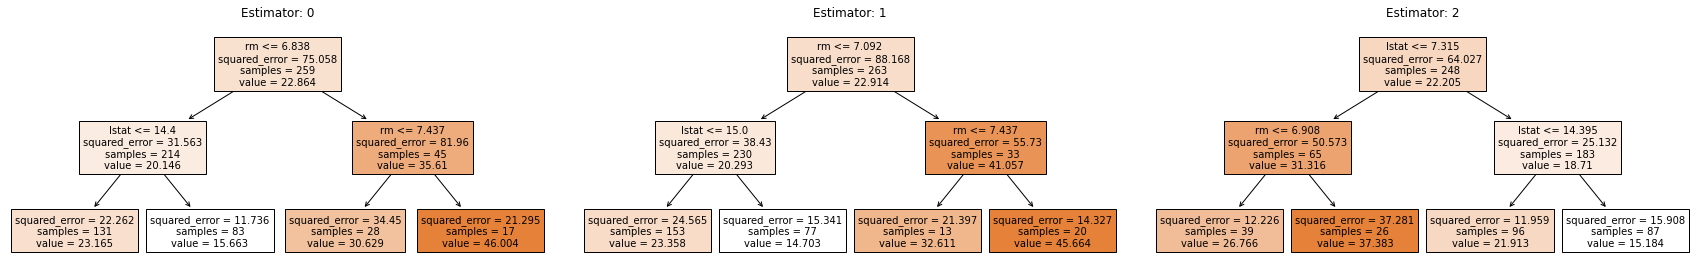

In [ ]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)

plt.tight_layout()
plt.show()

In [ ]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [ ]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.796750,0.0,0.0,0.0,0.0,0.0,0.0,0.203250
1,0.0,0.0,0.0,0.0,0.0,0.778023,0.0,0.0,0.0,0.0,0.0,0.0,0.221977
2,0.0,0.0,0.0,0.0,0.0,0.160598,0.0,0.0,0.0,0.0,0.0,0.0,0.839402


In [ ]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.578457
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
black      0.000000
lstat      0.421543
dtype: float64

In [ ]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.578457,0.0,0.0,0.0,0.0,0.0,0.0,0.421543


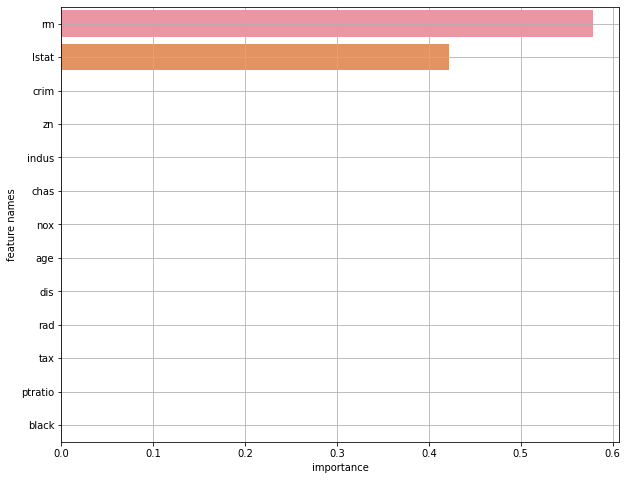

In [ ]:
result = plot_feature_importance(model.feature_importances_, list(x))

* tree = 100개 Random Forest 모델 만들기

In [ ]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

* 트리 전체 중요도 저장

In [ ]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [ ]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.038736,0.000803,0.001661,0.000653,0.005320,0.671782,0.009984,0.095599,0.001926,0.003522,0.018223,0.006657,0.145132
1,0.025357,0.000059,0.008939,0.001469,0.017589,0.609259,0.004803,0.062197,0.001564,0.014066,0.002455,0.020352,0.231893
2,0.010457,0.001612,0.010470,0.001423,0.010709,0.680187,0.008512,0.047662,0.001660,0.010648,0.010577,0.014081,0.192000
3,0.042984,0.004198,0.005057,0.002496,0.006058,0.174645,0.022819,0.025632,0.000534,0.013856,0.009762,0.005104,0.686856
4,0.023223,0.000086,0.002708,0.000335,0.033352,0.661611,0.012564,0.094219,0.000701,0.004143,0.012737,0.010783,0.143536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.015500,0.000158,0.006780,0.000396,0.002828,0.550189,0.012712,0.162247,0.003285,0.008758,0.010351,0.003220,0.223576
96,0.019357,0.001169,0.004121,0.002203,0.008980,0.637997,0.017315,0.124256,0.002034,0.007156,0.005837,0.004643,0.164931
97,0.040364,0.000090,0.000767,0.000000,0.018286,0.240654,0.011643,0.030790,0.006702,0.026987,0.029900,0.007066,0.586752
98,0.074876,0.000750,0.004793,0.000511,0.003780,0.647856,0.015873,0.011791,0.000973,0.010558,0.004673,0.013246,0.210320


* 트리 100개의 평균 중요도

In [ ]:
fi.mean(axis = 0)

crim       0.032596
zn         0.000758
indus      0.006178
chas       0.000806
nox        0.015807
rm         0.514895
age        0.014388
dis        0.071275
rad        0.002874
tax        0.009877
ptratio    0.012197
black      0.009383
lstat      0.308965
dtype: float64

In [ ]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.032596,0.000758,0.006178,0.000806,0.015807,0.514895,0.014388,0.071275,0.002874,0.009877,0.012197,0.009383,0.308965


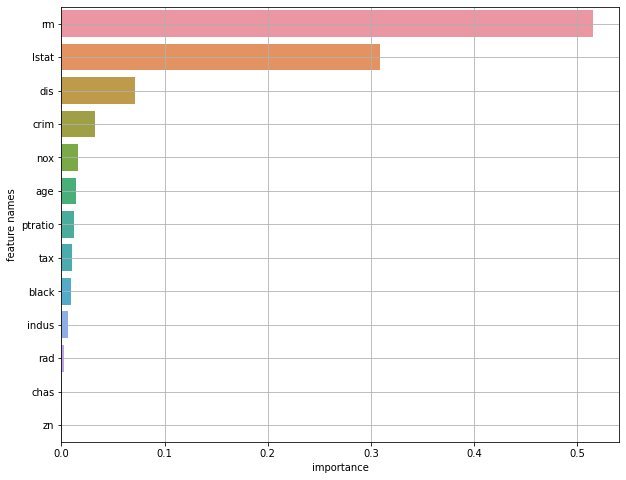

In [ ]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [ ]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.43149019607843


### 3) XGB

In [ ]:
from xgboost import XGBRegressor, plot_tree, plot_importance

* 기본 모델링

In [ ]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(max_depth=2, n_estimators=10, objective='reg:squarederror')

* plot tree
    * plot tree함수는 XGB에서 제공합니다.
    * XGB에서의 트리 시각화는 여러 estimator중 하나씩만 가능합니다.

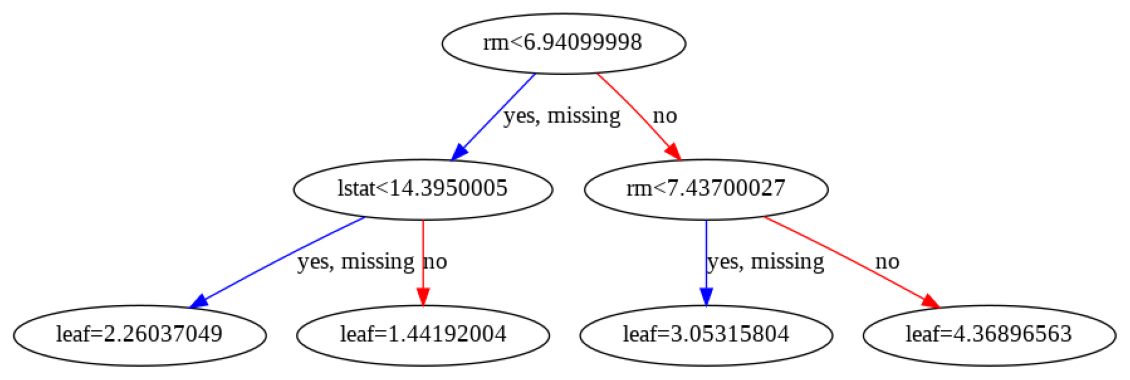

In [ ]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.

* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

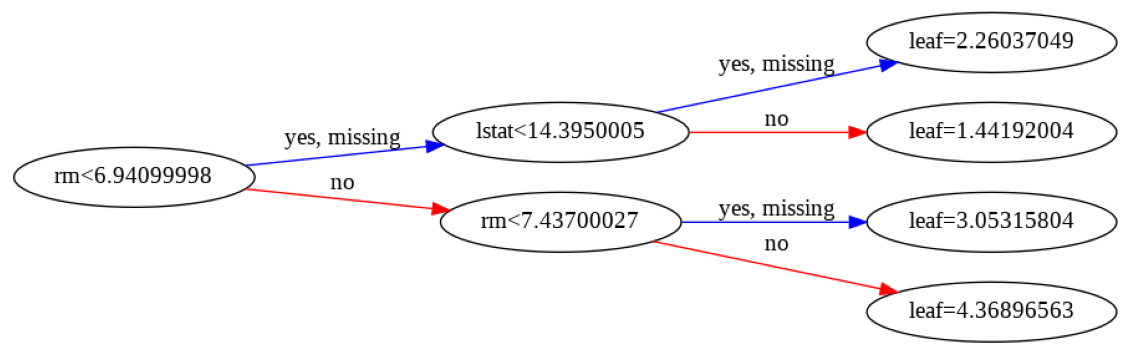

In [ ]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

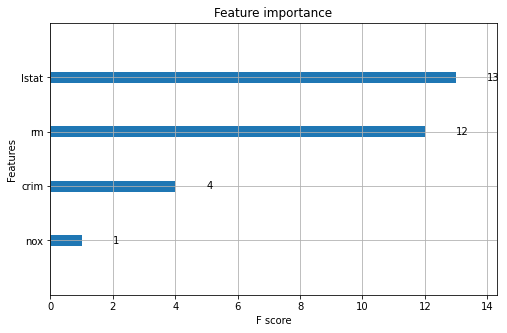

In [ ]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

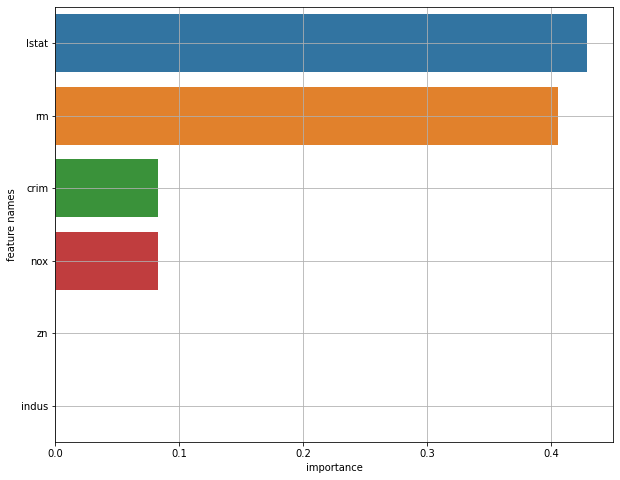

In [ ]:
result = plot_feature_importance(, list(x),6)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

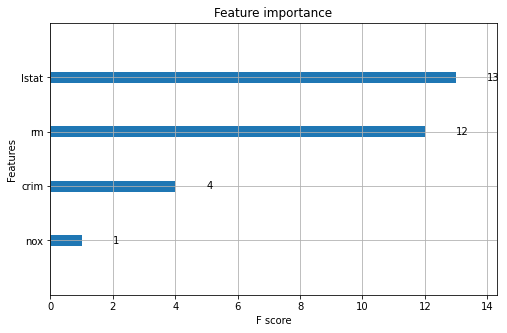

In [ ]:
# importance_type='weight'
plot_importance(model)
plt.show()

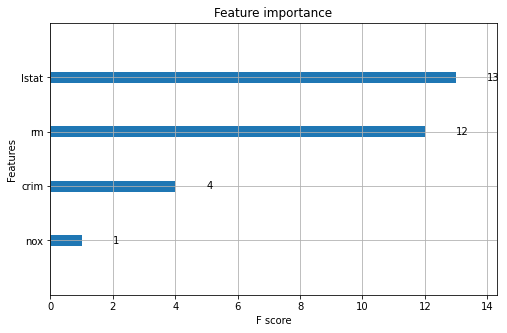

In [ ]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

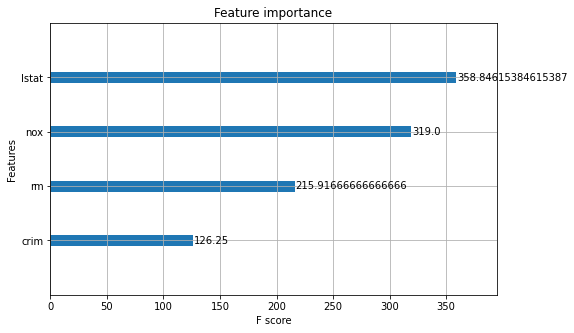

In [ ]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 1) 데이터 준비

* 데이터 로딩

In [ ]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [ ]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [ ]:
y.value_counts(normalize = True)

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [ ]:
dummy_vars = ['Department','EducationField','Gender','JobRole','MaritalStatus'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 20)

In [ ]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


* class balance를 맞추기 위한 resampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(y_train))
print(np.bincount(y_train) / y_train.shape[0])

[842 842]
[0.5 0.5]


### 2) 모델링 with Resampling
> * Resampling(up) 샘플링 데이터를 이용
* DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
* validate set으로 예측하고 평가(classification report)해 봅시다.
* 각각의 변수중요도 비교하기.



* 모델링
    * DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

* decision tree

In [ ]:
# depth의 범위 1~10까지 안에서 그리드서치로 튜닝해 봅시다.
params = {'max_depth':range(1, 20)}

model1 = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
model1.fit(sm_x_train, sm_y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20)})

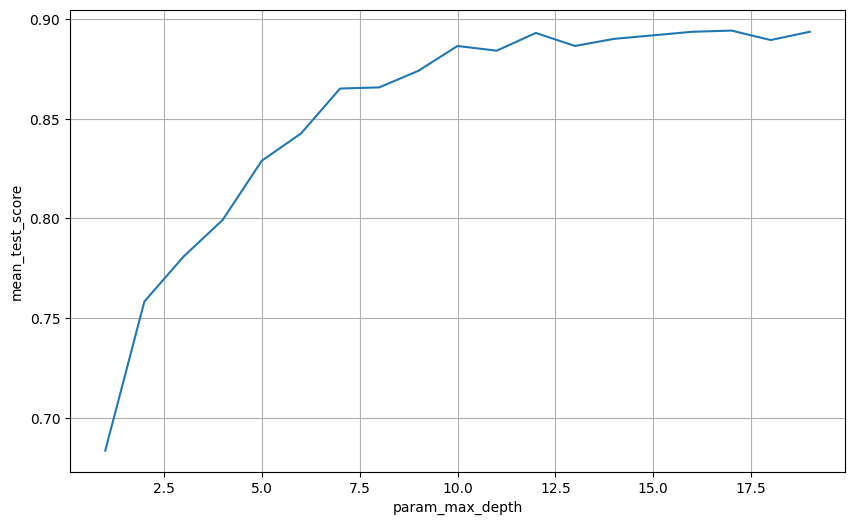

In [ ]:
# 튜닝 과정 로그를 df로 저장 합시다.
result = pd.DataFrame(model1.cv_results_)

# 튜닝 결과를 그래프로 그려봅시다.
plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

* rf

In [ ]:
# 기본값으로 모델을 생성합니다.
model2 = RandomForestClassifier()
model2.fit(sm_x_train, sm_y_train)

RandomForestClassifier()

* xgb

In [ ]:
# 다음 범위 안에서 그리드서치 튜닝을 진행합시다.
# max_depth : 1 ~ 6, learning_rate : 0.01 ~ 0.4, n_estimators : 50 ~ 150

params = {'max_depth':range(2, 6), 'learning_rate':np.linspace(0.01,0.4, 10)
            , 'n_estimators':[50,100,150]}

model3 = GridSearchCV(XGBClassifier(), params, cv = 5)
model3.fit(sm_x_train, sm_y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                         'max_depth': range(1, 6),
                         'n_estimators': [50, 100, 150]})

* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

In [ ]:
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
pred3 = model3.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, pred1 ))
print(classification_report(y_val, pred1 ))

[[173  35]
 [ 20   2]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       208
           1       0.05      0.09      0.07        22

    accuracy                           0.76       230
   macro avg       0.48      0.46      0.47       230
weighted avg       0.82      0.76      0.79       230



In [ ]:
print(confusion_matrix(y_val, pred2 ))
print(classification_report(y_val, pred2 ))

[[203   5]
 [ 20   2]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       208
           1       0.29      0.09      0.14        22

    accuracy                           0.89       230
   macro avg       0.60      0.53      0.54       230
weighted avg       0.85      0.89      0.87       230



In [ ]:
print(confusion_matrix(y_val, pred3 ))
print(classification_report(y_val, pred3 ))

[[202   6]
 [ 19   3]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       208
           1       0.33      0.14      0.19        22

    accuracy                           0.89       230
   macro avg       0.62      0.55      0.57       230
weighted avg       0.86      0.89      0.87       230



### 3) 변수 중요도 비교
* 세 모델간 변수 중요도를 비교해 봅시다.
* plot_feature_importance 함수 이용하기

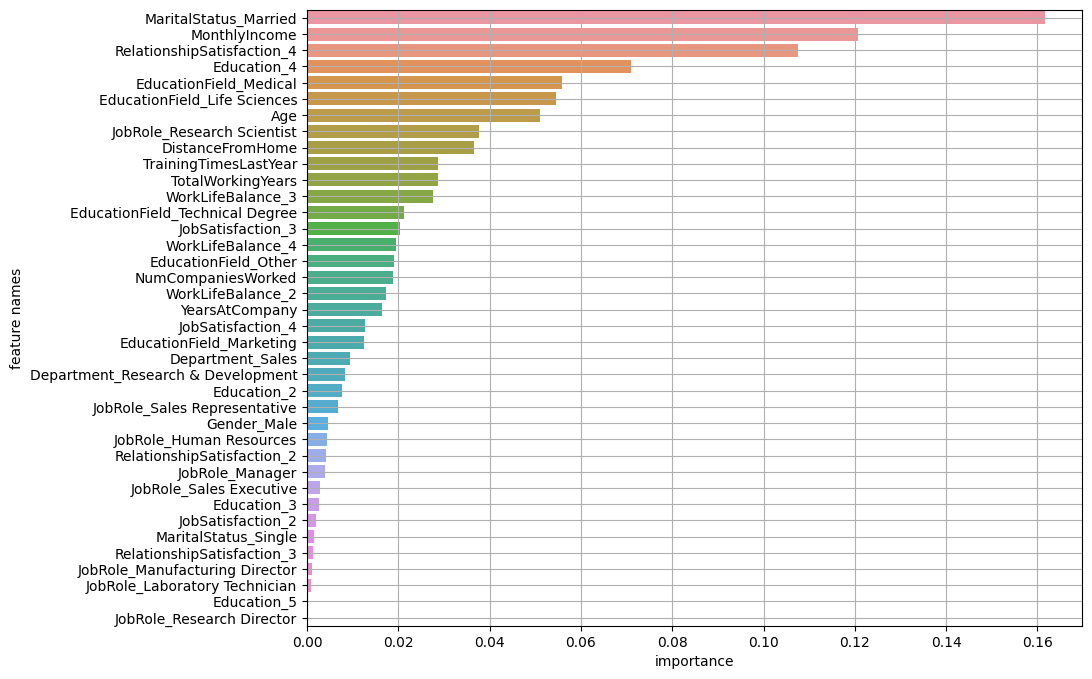

In [ ]:
# best 모델 저장
best_model1 = model1.best_estimator_

# 변수중요도
result1 = plot_feature_importance(best_model1.feature_importances_, list(x))

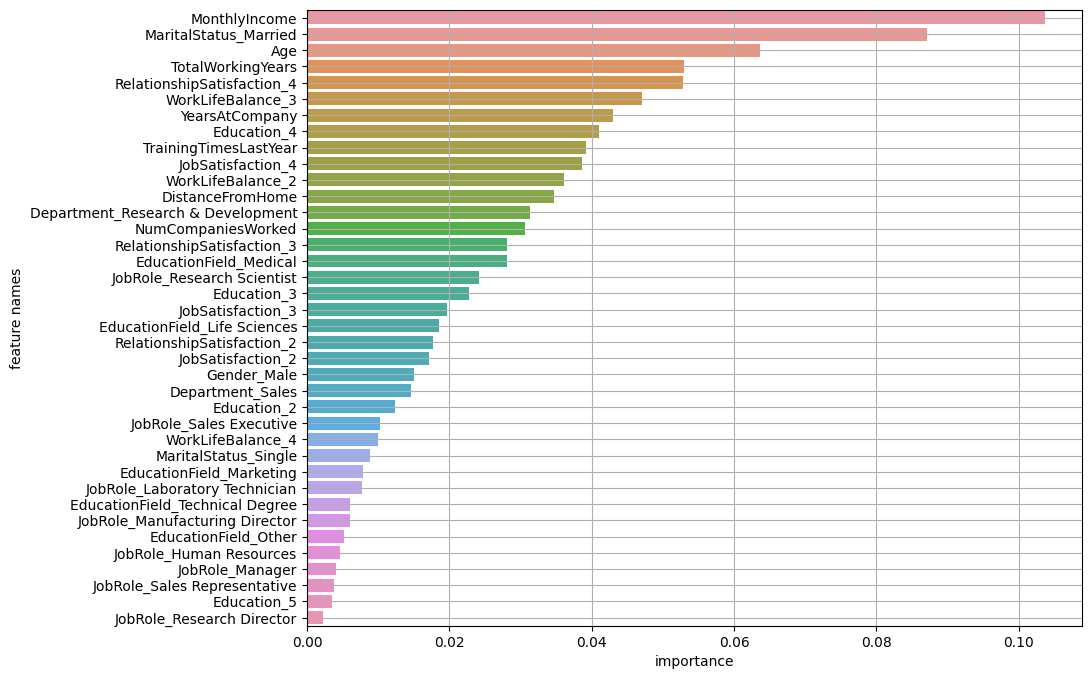

In [ ]:
# 변수중요도
result2 = plot_feature_importance(model2.feature_importances_, list(x))

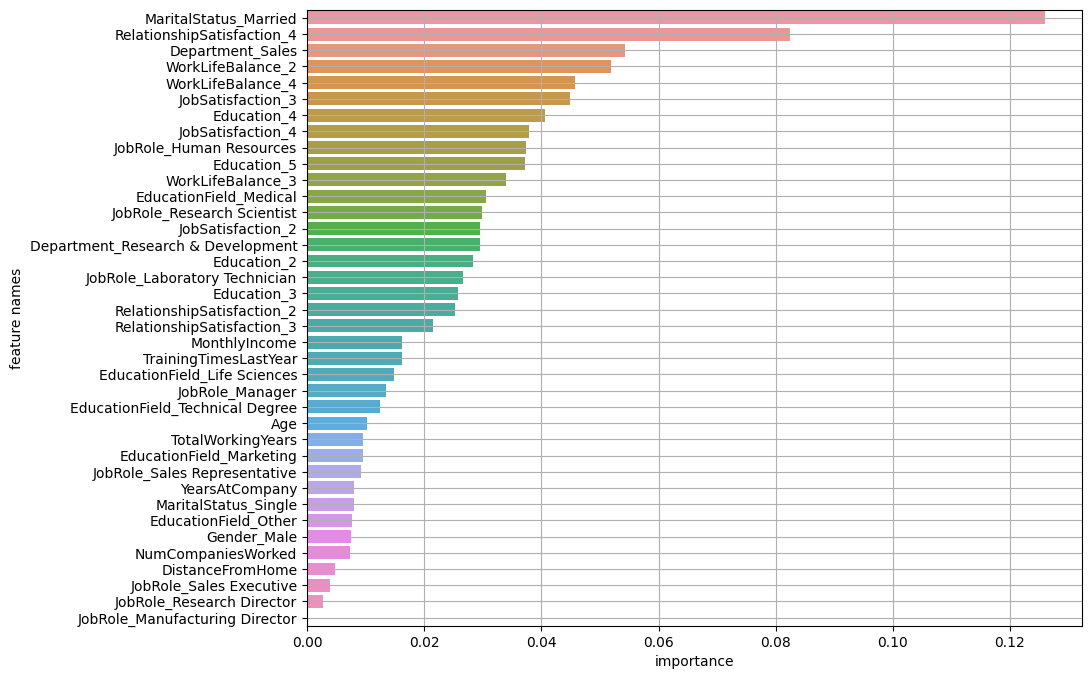

In [ ]:
# best 모델 저장
best_model3 = model3.best_estimator_

# 변수중요도
result3 = plot_feature_importance(best_model3.feature_importances_, list(x))

______
